# Mandatory Assignment 1

#### Part I: Multi-layer Perceptron

***

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [material/nns_pytorch.ipynb](material/nns_pytorch.ipynb)

Table of contents:
1. Activate GPU
2. Load data
3. Inspect data
4. Artificial neural network (**Where you will implement the ANN**)
5. Training hyperparameters (**Where you will add training parameters**)
6. Training
7. Plot loss and accuracy
8. Evaluate


In [35]:
# auxilary imports
import random
import matplotlib.pyplot as plt
import os
from pathlib import Path

# pytorch
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F  # noqa

First, a bit of a hack in case your IDE wants to run the notebook from /`assignment/` and not the project root folder `/ma1`. We need the working directory to be `/ma1` for local imports to work.

In [36]:
# Ensure the working directory is set to the "ma1" folder.
while Path.cwd().name != "ma1" and "ma1" in str(Path.cwd()):
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: c:\Users\togp\OneDrive - Implement\Desktop\AIML25\mas\ma1


##### Import local files

To declutter the notebooks, your are given a module (`/src`) of useful functions. Please study each one as they contain important code (particularly `src.training` and `src.evaluation`). 

In [37]:
# local files
from src.utils import get_device
from src.data import load_torch_data, to_dataloader, train_val_split
from src.training import fit
from src.evaluation import evaluate
from src.visualize import plot_training_history

### 1. Activate GPU
If available. Note that this is not necessary, but it will speed up your training.

In [38]:
# Device will determine whether to run the training on GPU or CPU.
DEVICE = get_device()

Running pytorch version (2.5.1) with backend = cpu


### 2. Load data

In [39]:
# load the training/validation data
train_val = load_torch_data(
    dataset="MNIST",
    root = 'data',                     # The root directory where the dataset will be stored
    download = True,                   # If the dataset is not found at root, it will be downloaded
    train = True,                      # The train dataset (as opposed to the test dataset)
    transform = transforms.ToTensor()  # transformations to be applied to the dataset (only cast to tensor)
)

# load the testing data
test = load_torch_data(
    dataset = "MNIST",
    root = 'data',
    download = True,
    train = False,
    transform = transforms.ToTensor()
)

f"{len(train_val)=}, {len(test)=}"

'len(train_val)=60000, len(test)=10000'

In [40]:
# split training data in training and validation (just like train_test_split in sklearn)
train, val = train_val_split(train_val, val_ratio=0.2, seed=42)

f"{len(val)=}, {len(train)=}"

'len(val)=12000, len(train)=48000'

In [41]:
# create dataloders for easy batch loading during training
train_loader = to_dataloader(train, batch_size = 64, shuffle = True)
val_loader = to_dataloader(val, batch_size = 64, shuffle = False)
test_loader = to_dataloader(test, batch_size = 64, shuffle = False)

### 3. Inspect data

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
Total pixels: 784
The label for this image: 0


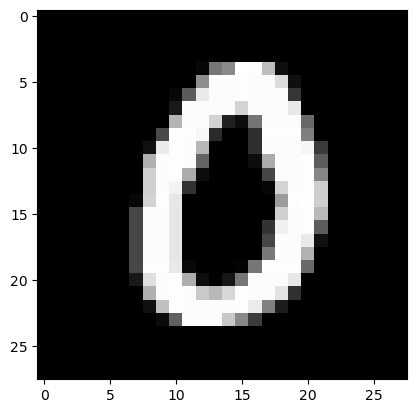

In [42]:
# Pick a random example from the training set
selection = random.randrange(len(train)-1)
image, label = train[selection]

# Plot the image
print(f"Default image shape: {image.shape}")
image = image.view([28,28])

print(f"Reshaped image shape: {image.shape}")
plt.imshow(image, cmap="gray")

print(f"Total pixels: {image.shape[0] * image.shape[1]}")

# Print the label
print(f"The label for this image: {label}")


***

### 4. Artificial neural network

In [43]:
class MLP(nn.Module):

    def __init__(self, input_size=784, hidden_size1=64, hidden_size2=32, output_size=10):
        super().__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)  # First layer
        self.relu1 = nn.ReLU()  # Activation function after first layer
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # Second layer
        self.relu2 = nn.ReLU()  # Activation function after second layer
        
        self.fc3 = nn.Linear(hidden_size2, output_size)  # Third layer (output)

    def forward(self, x: torch.Tensor):
        # Define forward pass
        x = self.fc1(x)  # First layer transformation
        x = self.relu1(x)  # Activation function
        
        x = self.fc2(x)  # Second layer transformation
        x = self.relu2(x)  # Activation function
        
        x = self.fc3(x)  # Third layer (output)
        return x


### 5. Training hyperparameters

In [44]:
LR = 0.001 # TODO: define the learning rate
NUM_EPOCHS = 20 # TODO: define the number of epochs (i.e. passes over the dataset)
criterion = nn.CrossEntropyLoss()  # The loss function

Instantiate the model and optimizer

In [45]:
model = MLP().to(DEVICE)   # Create an instance of the MLP model and move it to device (GPU or CPU)
optimizer = torch.optim.SGD(model.parameters(), lr=LR) # The optimizer (here, SGD - you can also try ADAM)

In [46]:
model

MLP(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

### 6. Training

In [47]:
model, history = fit(
    model,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    optimizer = optimizer,
    criterion = criterion,
    num_epochs = NUM_EPOCHS
)

Epoch [1/20]: Train Loss: 2.2998 | Train Accuracy: 12.80% | Val Loss: 2.2903 | Val Accuracy: 17.20%
Epoch [2/20]: Train Loss: 2.2775 | Train Accuracy: 21.60% | Val Loss: 2.2652 | Val Accuracy: 24.86%
Epoch [3/20]: Train Loss: 2.2472 | Train Accuracy: 28.24% | Val Loss: 2.2294 | Val Accuracy: 31.32%
Epoch [4/20]: Train Loss: 2.2026 | Train Accuracy: 36.67% | Val Loss: 2.1751 | Val Accuracy: 41.96%
Epoch [5/20]: Train Loss: 2.1354 | Train Accuracy: 44.48% | Val Loss: 2.0945 | Val Accuracy: 46.33%
Epoch [6/20]: Train Loss: 2.0390 | Train Accuracy: 49.61% | Val Loss: 1.9817 | Val Accuracy: 52.80%
Epoch [7/20]: Train Loss: 1.9092 | Train Accuracy: 54.77% | Val Loss: 1.8361 | Val Accuracy: 55.33%
Epoch [8/20]: Train Loss: 1.7500 | Train Accuracy: 56.99% | Val Loss: 1.6662 | Val Accuracy: 58.78%
Epoch [9/20]: Train Loss: 1.5737 | Train Accuracy: 60.70% | Val Loss: 1.4875 | Val Accuracy: 63.16%
Epoch [10/20]: Train Loss: 1.3966 | Train Accuracy: 65.94% | Val Loss: 1.3162 | Val Accuracy: 68.38%

### 7. Plot loss and accuracy

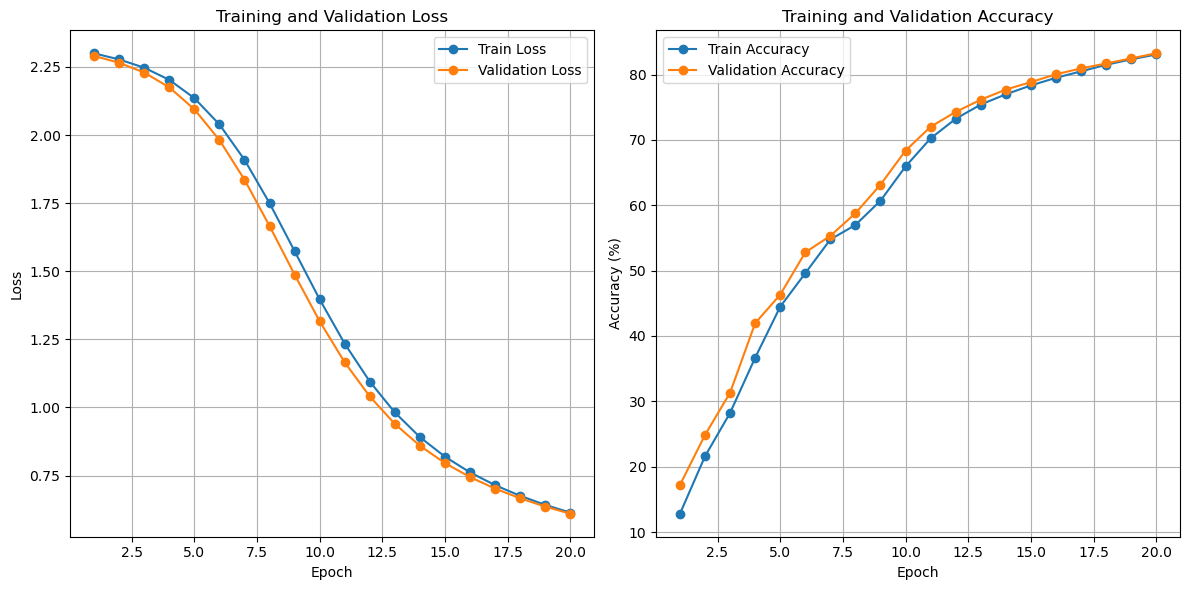

In [48]:
plot_training_history(history)

### 8. Evaluate

In [49]:
evaluate(
    model = model,
    data_loader = train_loader,  # evaluate on training data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.6003, Accuracy: 83.42%

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4735
           1       0.88      0.95      0.91      5383
           2       0.84      0.82      0.83      4762
           3       0.79      0.78      0.78      4886
           4       0.87      0.83      0.85      4681
           5       0.78      0.73      0.75      4368
           6       0.87      0.89      0.88      4752
           7       0.88      0.86      0.87      4983
           8       0.77      0.76      0.77      4674
           9       0.75      0.81      0.78      4776

    accuracy                           0.83     48000
   macro avg       0.83      0.83      0.83     48000
weighted avg       0.83      0.83      0.83     48000



In [50]:
evaluate(
    model = model,
    data_loader = val_loader,  # evaluate on validation data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.6098, Accuracy: 83.26%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1188
           1       0.89      0.95      0.92      1359
           2       0.82      0.79      0.81      1196
           3       0.80      0.79      0.79      1245
           4       0.86      0.82      0.84      1161
           5       0.79      0.76      0.77      1053
           6       0.87      0.88      0.87      1166
           7       0.88      0.87      0.87      1282
           8       0.79      0.78      0.79      1177
           9       0.72      0.78      0.75      1173

    accuracy                           0.83     12000
   macro avg       0.83      0.83      0.83     12000
weighted avg       0.83      0.83      0.83     12000



In [51]:
evaluate(
    model = model,
    data_loader = test_loader,  # evaluate on testing data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.5822, Accuracy: 83.62%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       980
           1       0.90      0.95      0.92      1135
           2       0.87      0.81      0.84      1032
           3       0.79      0.82      0.81      1010
           4       0.85      0.82      0.84       982
           5       0.77      0.72      0.74       892
           6       0.87      0.89      0.88       958
           7       0.87      0.84      0.86      1028
           8       0.80      0.76      0.78       974
           9       0.74      0.80      0.77      1009

    accuracy                           0.84     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000

